In [1]:
%reset
%matplotlib inline
print "Done."

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/home/charlie/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Done.


# Imports

In [2]:
#standard imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d as i1d

#other imports
from linear_growth_factor import E
#from WMB_scratch import Plognormal
from ExcessElectronLib import Prob_IGM # IGM distribution
from ExcessElectronLib import Convolve # Convolution function
from ExcessElectronLib import NormConv as Normalise # Normalisation function for P(DM|Z)
from ExcessElectronLib import NormTranspose # Normalisation function for P(z|DM)
from ExcessElectronLib import find_nearest # function to find nearest value in discrete array to specified value
from ExcessElectronLib import FindErrorRange # function to find min/max bounds for a PDF

print 'Imports done.'

Imports done.


# Import Host Galaxy Distributions

In [3]:
#########################################
###Stellar distributed FRBs in spirals###
#########################################

##OB STARS##
print "OB..."
OB_data=np.loadtxt('./host_galaxies/OB_FRBs_list.txt')
OB_DMs = zip(*np.array(OB_data))[0][:]

##YOUNG PULSARS##
print "YPSR..."
YPSR_data=np.loadtxt('./host_galaxies/young_FRBs_list.txt')
YPSR_DMs = zip(*np.array(YPSR_data))[0][:]

##OLD PULSARS##
print "OPSR..."
OPSR_data=np.loadtxt('./host_galaxies/old_FRBs_list.txt')
OPSR_DMs = zip(*np.array(OPSR_data))[0][:]

##MSPS##
print "MSP..."
MSP_data=np.loadtxt('./host_galaxies/msp_FRBs_list.txt')
MSP_DMs = zip(*np.array(MSP_data))[0][:]

"""
#Note: these are commented out to prevent importing huge numbers of files.

##########################################
#Homogenously distributed FRBs in spirals#
##########################################

##HOMOGENOUS35kpc##
print "H=35..."
H35_data=np.loadtxt('./host_galaxies/normal_FRBs_list.txt')
H35_DMs = zip(*np.array(H35_data))[0][:]

##HOMOGENOUS5kpc##
print "H=5..."
H5_data=np.loadtxt('./host_galaxies/normal_FRBs_list.txt')
H5_DMs = zip(*np.array(H5_data))[0][:]

##HOMOGENOUS0.2kpc##
print "H=0.2"
H0p2_data=np.loadtxt('./host_galaxies/normal_FRBs_list.txt')
H0p2_DMs = zip(*np.array(H0p2_data))[0][:]

##HOMOGENOUS0.004kpc##
print "H0=.004..."
H0p004_data=np.loadtxt('./host_galaxies/normal_FRBs_list.txt')
H0p004_DMs = zip(*np.array(H0p004_data))[0][:]

######################################################
#Elliptically distributed FRBs in Elliptical Galaxies#
######################################################

#ELLIPTICAL##
##RE=3.2kpc##
print "RE..."
ERE_data=np.loadtxt('./host_galaxies/elliptical_FRBs_list.txt')
ERE_DMs = zip(*np.array(ERE_data))[0][:]

##10RE##
print "10RE..."
E10RE_data=np.loadtxt('./host_galaxies/elliptical_FRBs_list.txt')
E10RE_DMs = zip(*np.array(E10RE_data))[0][:]

##1/10RE##
print "0.1RE..."
E0p1RE_data=np.loadtxt('./host_galaxies/elliptical_FRBs_list.txt')
E0p1RE_DMs = zip(*np.array(E0p1RE_data))[0][:]

#########################################################
#Homogenous FRB distributions within elliptical galaxies#
#########################################################

#HOMOGENOUS##
##RE=3.2kpc##

##PLEASE NOTE: This is a larger file and must be downloaded separately.
## File can be found here: https://drive.google.com/file/d/1AFonTGRxss1rkjt7ZlpoTKKiS9kKN08r/view?usp=sharing

#HRE_data=np.loadtxt('./host_galaxies/normal_FRBs_list.txt')
#HRE_DMs = zip(*np.array(HRE_data))[0][:]
"""

print 'Host distributions imported.'

OB...
YPSR...
OPSR...
MSP...
Host distributions imported.


# Function to refresh continuous host galaxy distribution function

In [4]:
def ContinuousHost():
    """
    When switching between host galaxy models this must be called after selecting your model.
    Creates the continuous PDF(DM|Z=0) function for a host galaxy which will be sampled during analysis.
    """
    
    class HostContinuous:
        
        """
        Note, to pass stuff into a class: https://ubuntuforums.org/showthread.php?t=578930
        """
        
        DM_min = np.min(binCents)
        DM_max = np.max(binCents)
        Host_PDF = i1d(binCents,ydata)
    
    # Function to sample continuous PDF
    
    def HostProb(DM):
        
        """
        Returns the probability of finding an FRB of particular DM, given a Host Galaxy model.
        
        INPUTS
        
        DM : a single float or array of floats representing dispersion measures
             to calculate probabilities for.
        
        RETURNS
        
        P  : probability/probabilities of finding the input DMs.
        
        """
        
        if isinstance(DM,(list,np.ndarray,tuple)): #if dm is a list of values
            
            P = np.zeros_like(DM) #create list for P(DM)
            
            for i in range(len(DM)): #loop over dms
                
                if (DM[i]<=HostContinuous.DM_max) & (DM[i]>=HostContinuous.DM_min): #if dm is in limits
                    
                    P[i] = HostContinuous.Host_PDF(DM[i]) #calculate P(DM)
                    
                else: #else if dm is outside limits
                    
                    P[i] = 0.0 #P(DM)=0
                    
        else: #else if dm is a value
            
            if (DM<=HostContinuous.DM_max) & (DM>=HostContinuous.DM_min): #if dm is in limits
                
                P = HostContinuous.Host_PDF(DM) #calculate P(DM)
                
            else: #else if dm is outside limits
                
                P = 0.0 #P(DM)=0
    
        P = np.array(P) #convert to array
        
        #find places where P is infinite and replace with zero
        indices = np.isfinite(P)
        P[~indices] = 0 #tilde is the NOT operator, which returns the inverse of indices
            
        return P 
    
    return HostProb

# Function for creating P(DM|Z)

In [5]:
def EEModel(HostProb,DM,z):
    
    """
    Creates the excess electron model (P(DM|zs)) for a given host probability function, DM list and redshit list.
    
    Inputs:
    
    HostProb : Host probability function to use
    DM       : (array-like) input DM list to create probabilities for
    z        : (array-like) input redshift list to create probabilities for
    
    Returns:
    
    parray : (array-like) two dimensional array of probabilities
    DM_    : (array-like) output redshift list to be used with parray
    
    """
    
    parray=[]
    
    #Note that if your host probability function returns a bunch of zeros, it will convolve with
    #zeros and give you a P(DM|z) of nothing. Therefore you cannot just put in a constant distribution
    #of numbers and get the probability of the IGM only.
    #The next if statement works around that.
    
    if np.sum(HostProb(DM))==0.0: #check for IGM-only model
        
        print "Warning: host distribution error. Host has no chance of returning input DMs. Returning IGM probability only."
        for zs in z:
            
            Pdmz = Prob_IGM(DM,zs)
            parray.append(Pdmz)
            
        DM_=DM
    
    else: #Other models
        for zs in z:                                      #for each source redshift   
            Pdmz, DM_ = Convolve(Prob_IGM,HostProb,DM,zs) #calculate P(DM|zs) and get new DM list
            parray.append(Pdmz)                           #append P(DM|zs) to array
        
    return parray,DM_

# Import current FRBcat FRBs

In [6]:
#NOTE THESE DATA WERE IMPORTED FROM THE FRB CATALOGUE: http://frbcat.org/ (Petroff et. al 2016) (http://adsabs.harvard.edu/abs/2016PASA...33...45P)

#the data
FRBdat=np.loadtxt('FRBcat_FRB_DMs.csv',dtype='str',delimiter=',',skiprows=1)
#all frb names
FRBnames = FRBdat[:,0]
#all observed FRB DMs
FRBdms = FRBdat[:,-1]
FRBdms = np.char.strip(FRBdms,'"')
FRBdms = [float(i.split('&')[0]) for i in FRBdms] #reformat frb dms into floats
#all FRB MW contributions
FRBmws = FRBdat[:,-2]
FRBmws = np.char.strip(FRBmws,'"')
FRBmws = [float(i.split('&')[0]) for i in FRBmws] #reformat frb mw contributions into floats
#calculate excess dm for frbs
FRBexc = [FRBdms[i]-FRBmws[i] for i in range(len(FRBdms))]

# Example: The excess electron model for a particular host

## Choose a host (alternatively, insert your own host PDF)

In [7]:
DMs = YPSR_DMs

## Create P(DM|zs) excess electron model

In [8]:
# Create histogram from data from which to sample for continuous PDF
nBins = 2000 # Number of bins in histogram
ydata,binEdges = np.histogram(DMs,bins=nBins,weights=np.ones_like(DMs)/len(DMs),normed=True) # Y-axis of histogram (aka probabilities) and bin edges
binCents=0.5*(binEdges[1:]+binEdges[:-1]) # Bin centers

# Create continuous host PDF
HostProb = ContinuousHost()

# Initialise
DM = np.arange(0.,24000.,10)                      #range of DM values for convolution
DM+=(DM[1]-DM[0])/2                               #center the DM bins
z = np.linspace(0,6,601)                          #range of source redshifts (zs) to calculate P(DM|zs) for
z+=(z[1]-z[0])/2                                  #center the redshift bins

parray,DM_=EEModel(HostProb,DM,z)                #Create P(DM|z)
parray=np.array(parray)                           #convert to numpy array
parray=Normalise(parray,DM_)                      #Normalise P(DM|zs) array


True
(601, 4799)


## Plot model

True
(1, 2400)
True
(1, 2400)
True
(1, 2400)
True
(1, 2400)
True
(1, 2400)
True
(1, 2400)
True
(1, 2400)


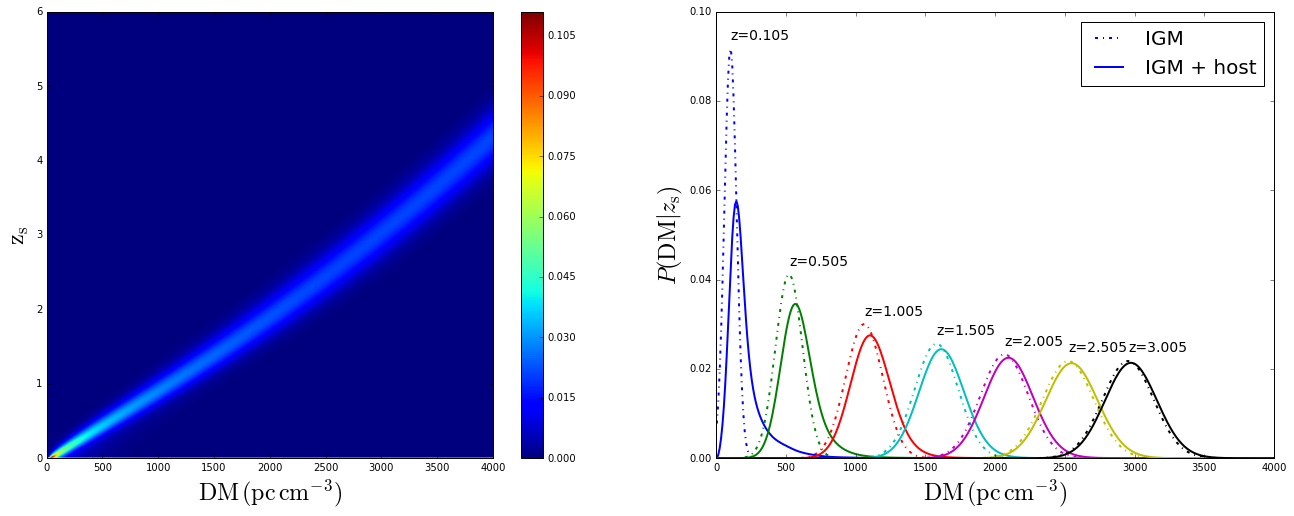

In [9]:
fig=plt.figure(figsize=(22,8))

ax = fig.add_subplot(121)
ax.set_xlabel(r'${\rm DM\,(pc\,cm^{-3})}$',size=24)
ax.set_ylabel(r"${\rm z_{s}}$",size=24)
ax.set_xlim(0,4000)
ax.set_ylim(0,6)

a = ax.imshow(parray,aspect='auto',origin='lower',extent=[DM_[0],DM_[-1],z[0],z[-1]])
cbar1 = fig.colorbar(a,ax=ax)

ax2 = fig.add_subplot(122)
ax2.set_xlabel(r'${\rm DM\,(pc\,cm^{-3})}$',size=24)
ax2.set_ylabel(r'$P({\rm DM}|z_{\rms})$',size=24)

ax2.set_xlim(0,4000)

redshift_cuts = np.array([0.1,0.5,1.0,1.5,2.0,2.5,3.0])+0.005
redshift_inds=np.where([z==i for i in redshift_cuts])[1]

for i,redshift_cut,redshift_ind in zip(np.arange(len(redshift_cuts)),redshift_cuts,redshift_inds): #loop over redshifts

    #create IGM plot
    pigm = Prob_IGM(DM,redshift_cut)
    pigm = np.reshape(pigm,(1,pigm.shape[0]))
    pigm=np.squeeze(Normalise(pigm,DM))
    
    if i==0:
        cax = ax2.plot(DM,pigm,'-.',lw=2,label = 'IGM')
    else:
        cax = ax2.plot(DM,pigm,'-.',lw=2)
    
    ymax=np.max(pigm)
    xmax=DM[np.where(pigm==ymax)[0]]
    ax2.annotate('z={0}'.format(redshift_cut), 
                xytext = (xmax+0.1,ymax+0.002),
                xy = (xmax,ymax),
                fontsize=14
                ) #label curve with frb name    
    

for i,redshift_cut,redshift_ind in zip(np.arange(len(redshift_cuts)),redshift_cuts,redshift_inds): #loop over redshifts
    
    
    #create igm + host plot
    
    if i==0:
        cax = ax2.plot(DM_,parray[redshift_ind,:],'-',lw=2,label = 'IGM + host')
    else:
        cax = ax2.plot(DM_,parray[redshift_ind,:],'-',lw=2)

plt.legend(fontsize=20)
plt.savefig('fig-host-redshift-relation.png',bbox_inches='tight')
plt.show()

# Example: Renormalise excess electron model along P(zs|DM) axis

True
ERLANG DISTRIBUTION FOR FRBS IMPLEMENTED
8.67361737988e-19 6.01 601


ExcessElectronLib.py:333: RuntimeWarning: divide by zero encountered in divide
  Convolution_Matrix[:,d]/=norm                                                                             #normalise P(DM|z)
ExcessElectronLib.py:333: RuntimeWarning: invalid value encountered in divide
  Convolution_Matrix[:,d]/=norm                                                                             #normalise P(DM|z)


29


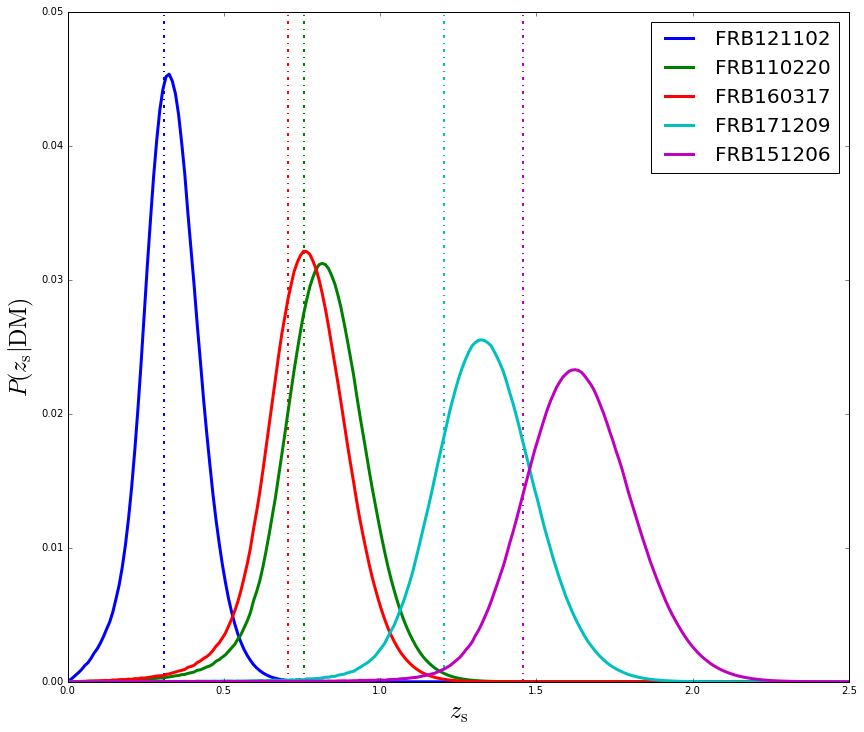

In [10]:
# Renormalise
parray = NormTranspose(parray,z,erlang=True) #normalise, set Erlang redshift distribution for FRBs to true
parray = np.nan_to_num(parray) #remove nan values

#find discrete dm (from range used to create convolution) closest to dm excess for each FRB
FRBexc_discrete = [find_nearest(DM_,dm) for dm in FRBexc]

#plot cuts of P(z|DM) for particular DMs (chosen from FRBcat FRBs)

dm_cuts = np.array(FRBexc_discrete[0:-1])               #dm cuts to plot
dm_locs = np.where([DM_==i for i in dm_cuts])[1]        #indexes of cuts (to extract from parray)

print len(dm_cuts)

pmax = [] #initialise array to hold FRB maximum likelihood redshifts
FRBpdfs = [] #initialise array to hold P(z|DM) curves


#plot FRB redshift probability curves

fig=plt.figure(figsize=(14,12))

ax=fig.add_subplot(111)

ax.set_xlabel(r'$z_{\rm s}$',size=24)
ax.set_ylabel(r'$P(z_{\rms}|{\rm DM})$',size=24)
#ax.set_title('P(zs|DM) redshift cuts')
ax.set_xlim((0,2.5))
ax.set_ylim((0,0.05))

#initialise colors for plotting
colorlist=['b','g','r','c','m']
col_idx=-1

for idx,dm,name,dm_excess in zip(dm_locs,dm_cuts,FRBnames,FRBexc): #loop over redshift cuts
        
    if idx%6==0:# only plot a few
        
        col_idx+=1
        col=colorlist[col_idx]                                     #select color for line plot
        pdf = parray[:,idx]                                          #get the pdf P(z|DM)
        FRBpdfs.append(pdf)                                          #append to array
        name = name                                                  #get frb name
    
        ymax = np.max(pdf)                                           #get maximum of P(z|dm)
        xpos = np.where(pdf==ymax)                                   #get index of maximum
        xmax = z[xpos]                                               #get redshift related to maximum of P(z|dm)
        pmax.append(xmax)                                            #append to array
    
        _z = z                                                       #get DMs
        _P = pdf                                                     #get P(DM|zs)
        plt.plot(_z,_P,'-',lw=3,color=col,label='{0}'.format(name.split('"')[1]))#plot redshift cuts for convolution
        
        plt.vlines(dm_excess/1200.,0,0.08,color=col,lw=2,linestyles='dashdot')
    
plt.legend(fontsize=20)
plt.savefig('fig-WMB-inversion.png',bbox_inches='tight')
plt.show()

# Example: Compare Erlang vs homogeneous redshift distributions for FRB121102


#### INITIALISING ##### 


###### CREATING P(DM|Z) #######

True
(601, 4799)
True
(601, 4799)

###### CREATING P(z|DM) #######

True
8.67361737988e-19 6.01 601
True
ERLANG DISTRIBUTION FOR FRBS IMPLEMENTED
8.67361737988e-19 6.01 601

###### FRB INFORMATION #########


##### FRB DM CUTS ######


##### FRB PZDMs ######

0.00412535111786 [ 0.17065521] [ 0.85065521]
symmetric
CDF reference point:  [ 0.51065521]
CDF boundaries:  [ 0.17065521] [ 0.85065521]
CDF discretes:  [0.17127142183525923, 0.8560738258211994]
CDF discretes indexes:  [20, 40]
CDF index boundaries:  [[19, 20], [39, 40]]
CDF boundaries:  [[0.15244126735234376, 0.17127142183525923], [0.83240141674220813, 0.8560738258211994]]
x-array boundaries:  [[0.19500000000000001, 0.20500000000000002], [0.39500000000000002, 0.40500000000000003]]
fractions:  [ 0.96727513] [ 0.77109983]
0.00412535111786 [ 0.03565521] [ 0.98565521]
symmetric
CDF reference point:  [ 0.51065521]
CDF boundaries:  [ 0.03565521] [ 0.98565521]
CDF discretes:  [

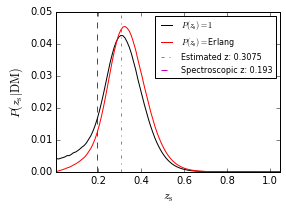

In [11]:
#Choose FRB index to plot (FRB121102 is index 6 with default dataset)
frb_index = 6

fig=plt.figure(figsize=(4,2.87))

ax1=fig.add_subplot(111)
ax1.set_ylim(0,0.05)

#choose host galaxy model to use
models = [YPSR_DMs]
modelnames = ["YPSR_DMs"]

#set axes for plot
axes = [ax1]

for m in range(len(models)):
    
    #Initialise host galaxy
    DMs = models[m] #select DM model 
    nBins = 2000 # Number of bins in histogram
    ydata,binEdges = np.histogram(DMs,bins=nBins,weights=np.ones_like(DMs)/len(DMs),normed=True) # Y-axis of histogram (aka probabilities) and bin edges
    binCents=0.5*(binEdges[1:]+binEdges[:-1]) # Bin centers

    # Continuous PDF
    HostProb = ContinuousHost()
    
    #initial parameters
    print '\n#### INITIALISING #####','\n'
    DM = np.arange(0.,24000.,10) #range of DM values for convolution
    DM+=(DM[1]-DM[0])/2 #center the DM bins
    z = np.linspace(0,6,601) #range of source redshifts (zs) to calculate P(DM|zs) for
    z+=(z[1]-z[0])/2 #center the redshift bins
    
    
    #create P(DM|z)
    print '\n###### CREATING P(DM|Z) #######\n'
    parray,DM_=EEModel(HostProb,DM,z)
        
    parray=np.array(parray)                           #convert to numpy array
    parray_E = np.copy(parray)                        #copy for erlang
    
    parray=Normalise(parray,DM_)                      #Normalise P(DM|zs) array
    parray_E = Normalise(parray_E,DM_)                 #Normalise Erlang
    
    #renormalise for P(z|DM)
    print '\n###### CREATING P(z|DM) #######\n'

    parray = NormTranspose(parray,z,erlang=False)   #normalise w/o erlang
    parray_E = NormTranspose(parray_E,z,erlang=True) #normalise w/ erlang
    
    parray = np.nan_to_num(parray) #remove nan values
    parray_E = np.nan_to_num(parray_E) #remove nan values
    
    #Current FRBcat FRBs
    print '\n###### FRB INFORMATION #########\n'
    FRBexc_discrete = [find_nearest(DM_,dm) for dm in FRBexc] #find discrete dm (used to create convolution) closest to dm excess for each FRB

    #FRB DM cuts
    print '\n##### FRB DM CUTS ######\n'
    dm_cuts = np.array(FRBexc_discrete[0:-1])               #dm cuts to plot
    dm_locs = np.where([DM_==i for i in dm_cuts])[1]        #indexes of cuts (to extract from parray)
    
    #FRB PDFs
    print '\n##### FRB PZDMs ######\n'
    FRBpdfs   = []
    FRBpdfs_E = []
    
    for idx in dm_locs:                #loop over redshift cuts
        
        pdf   = parray[:,idx]          #get the pdf P(z|DM) w/o erlang
        pdf_E = parray_E[:,idx]        #get the pdf P(z|DM) w/ erlang
        
        FRBpdfs.append(pdf)            #append w/o erlang
        FRBpdfs_E.append(pdf_E)        #append w/ erlang
    
    #Select FRB to plot
    for furby in [frb_index]:  #6 is frb121102
        i=furby
        
        pzdm = FRBpdfs[i] #get correct model w/o erlang
        pzdm_E = FRBpdfs_E[i] #get correct model w/ erlang

        name = FRBnames[i]#get frb name
        
        #create cumulative sum
        cumsum=np.cumsum(pzdm)     # w/o erlang
        cumsum_E=np.cumsum(pzdm_E) # w/ erlang

        
    #plot
        ax = axes[m] #select correct axis
        ax.set_xlabel(r'$z_{\rm s}$',size=12)
        ax.set_ylabel(r'$P(z_{\rms}|{\rm DM})$',size=12)
        #ax.set_title(name)
        xaxismax = _z[np.where(cumsum>0.99999999)[0][0]]
        
        ax.set_xlim(np.min(_z),xaxismax)



        ax.plot(_z,pzdm,'-',lw=1,color='k',label=r'$P(z_{\rm s})=1$') #plot pdf w/o erlang
        ax.plot(_z,pzdm_E,'-',lw=1,color='r',label=r'$P(z_{\rm s})=$Erlang') #plot pdf w/o erlang

        


        #get mode of PDF
        pdfmax = np.where(pzdm==np.max(pzdm))
        mod_redshift = _z[pdfmax]


        #choose percentage of probability to be contained within uncertainties
        s1=0.68      
        s2=0.95
        s3=0.997

        #set reference value to draw errors from (mode or median)
        ref = mod_redshift[0]
         
        #get uncertainty range
        [zmin1,zmax1] = FindErrorRange(pzdm,_z,ref,s1)
        [zmin2,zmax2] = FindErrorRange(pzdm,_z,ref,s2)
        [zmin3,zmax3] = FindErrorRange(pzdm,_z,ref,s3)

        #plot 1-sigma uncertainty range
    
        #interpolate to fill between the exact error boundaries
        xfill1=np.linspace(zmin1,zmax1,10000)
        yfill1= np.interp(xfill1,_z,pzdm)

        #ax.fill_between(xfill1,
        #                0.,
        #                yfill1,
        #                facecolor='gray',
        #                alpha=0.3,
        #                interpolate=True,
        #                label='1-$\sigma$')
    

    
        #plot 2-sigma uncertainty range
    
        #interpolate to fill between the exact error boundaries
        #xfill2=np.linspace(zmin2,zmax2,10000)
        #yfill2= np.interp(xfill2,_z,pzdm)

        #ax.fill_between(xfill2,
        #                 0.,
        #                 yfill2,
        #                 facecolor='gray',
        #                 alpha=0.2,
        #                 interpolate=True,
        #                 label='2-$\sigma$')

    
        #plot frbcat estimate redshift

        ax.vlines(FRBexc[i]/1200.,
                   np.min(pzdm),
                   0.08,
                   colors='c',
                   linestyles='dashdot',
                   lw=1,
                   label=r"Estimated z: {0}".format(FRBexc[i]/1200.))    
    
        if i==6:
    
                ax.vlines(0.192738,
                          np.min(pzdm),
                          0.08,
                          colors='m',
                          linestyles='dashed',
                          lw=1,
                          label='Spectroscopic z: {0}'.format(0.193))
        
        
        
        
    #plot legend
        ax.legend(fontsize=8)
        
plt.savefig('fig-homogenous-v-erlang.pdf',dpi=300,format='pdf',bbox_inches='tight')



# Example: Constrain redshifts for current FRBs using various models

## Constrain redshifts

In [12]:
#choose models to use

IGM_ONLY = np.ones(100000)

models = [IGM_ONLY,
         YPSR_DMs,
         OPSR_DMs,
         OB_DMs,
         MSP_DMs]

modelnames = ["${\rm IGM\,only}$",
         r"${\rm YPSR}$",
         r"${\rm H=0.2\,kpc}$",
         r"${\rm R_{e}=3.2\,kpc}$",
         r"${\rm H=0.1\,kpc}$"]

#initialise array to hold every redshift,error
FRBdat=np.loadtxt('FRBcat_FRB_DMs.csv',dtype='str',delimiter=',',skiprows=1) #the data
FRBnames = FRBdat[:,0]    #all frb names
FRBdms = FRBdat[:,-1]     #all observed FRB DMs
FRBdms = np.char.strip(FRBdms,'"')
FRBdms = [float(i.split('&')[0]) for i in FRBdms] #reformat frb dms into floats
FRBmws = FRBdat[:,-2]    #all FRB MW contributions
FRBmws = np.char.strip(FRBmws,'"')
FRBmws = [float(i.split('&')[0]) for i in FRBmws] #reformat frb mw contributions into floats
    
FRBexc = [FRBdms[i]-FRBmws[i] for i in range(len(FRBdms))] #calculate excess dm for frbs
#FRBexc_discrete = [find_nearest(DM_,dm) for dm in FRBexc]

furby_redshifts = np.zeros((len(FRBexc),len(models)))
furby_mins_1sig = np.zeros((len(FRBexc),len(models)))
furby_mins_2sig = np.zeros((len(FRBexc),len(models)))
furby_maxs_1sig = np.zeros((len(FRBexc),len(models)))
furby_maxs_2sig = np.zeros((len(FRBexc),len(models)))

#loop over desired models
for m in range(len(models)):
    
    #Initialise Host PDF
    DMs = models[m] #select DM model 
    nBins = 2000 # Number of bins in histogram
    ydata,binEdges = np.histogram(DMs,bins=nBins,weights=np.ones_like(DMs)/len(DMs),normed=True) # Y-axis of histogram (aka probabilities) and bin edges
    binCents=0.5*(binEdges[1:]+binEdges[:-1]) # Bin centers
     
    # Continuous Host PDF
    HostProb=ContinuousHost() 
    
    
    #initial parameters
    print '\n#### INITIALISING #####','\n'
    DM = np.arange(0.,24000.,5) #range of DM values for convolution
    DM+=(DM[1]-DM[0])/2 #center the DM bins
    z = np.linspace(0,6,1201) #range of source redshifts (zs) to calculate P(DM|zs) for
    z+=(z[1]-z[0])/2 #center the redshift bins
        
    #create P(DM|z)
    print '\n###### CREATING P(DM|Z) #######\n'
    parray,DM_=EEModel(HostProb,DM,z)
        
    parray=np.array(parray)                           #convert to numpy array    
    parray=Normalise(parray,DM_)                      #Normalise P(DM|zs) array
    
    #renormalise for P(z|DM)
    print '\n###### CREATING P(z|DM) #######\n'

    parray = NormTranspose(parray,z,erlang=False)   #normalise w/ erlang    
    parray = np.nan_to_num(parray) #remove nan values    
    
    #FRB info
    #initialise array to hold every redshift,error
    FRBexc_discrete = [find_nearest(DM_,dm) for dm in FRBexc]
    
    
    #FRB DM cuts
    print '\n##### FRB DM CUTS ######\n'
    dm_cuts = np.array(FRBexc_discrete[0:])               #dm cuts to plot
    dm_locs = np.where([DM_==i for i in dm_cuts])[1]        #indexes of cuts (to extract from parray)
    
    #FRB PDFs
    print '\n##### FRB PZDMs ######\n'
    FRBpdfs   = []
    FRBpdfs_E = []
    
    
    for idx in dm_locs:                #loop over redshift cuts
        
        pdf   = parray[:,idx]          #get the pdf P(z|DM) w/o erlang        
        FRBpdfs.append(pdf)            #append w/o erlang
                    
    #Select FRB to plot
    for furby in range(30):  #6 is frb121102

        i=furby
        
        pzdm = FRBpdfs[i] #get correct model w/o erlang
        name = FRBnames[i]#get frb name
        
        #create cumulative sum
        cumsum=np.cumsum(pzdm)     # w/o erlang

        #get mode of PDF
        pdfmax = np.where(pzdm==np.max(pzdm))
        mod_redshift = z[pdfmax]

        #append to array
        furby_redshifts[i,m] = mod_redshift

        #choose percentage of probability to be contained within uncertainties
        s1=0.68      
        s2=0.95
        s3=0.997

        #set reference value to draw errors from (mode or median)
        ref = mod_redshift[0]
         
        #get uncertainty range
        [zmin1,zmax1] = FindErrorRange(pzdm,z,ref,s1)
        [zmin2,zmax2] = FindErrorRange(pzdm,z,ref,s2)
        [zmin3,zmax3] = FindErrorRange(pzdm,z,ref,s3)
        
        furby_mins_1sig[i,m]=zmin1
        furby_mins_2sig[i,m]=zmin2
        furby_maxs_1sig[i,m]=zmax1
        furby_maxs_2sig[i,m]=zmax2



#### INITIALISING ##### 


###### CREATING P(DM|Z) #######

True
(1201, 4800)

###### CREATING P(z|DM) #######

True
4.33680868994e-19 6.005 1201

##### FRB DM CUTS ######


##### FRB PZDMs ######

1.42019529815e-89 [ 0.05840178] [ 0.73840178]
symmetric
CDF reference point:  [ 0.39840178]
CDF boundaries:  [ 0.05840178] [ 0.73840178]
CDF discretes:  [0.057977829821912449, 0.7396864877052246]
CDF discretes indexes:  [16, 36]
CDF index boundaries:  [[16, 17], [35, 36]]
CDF boundaries:  [[0.057977829821912449, 0.079603161684515492], [0.7133410407163765, 0.7396864877052246]]
x-array boundaries:  [[0.082500000000000004, 0.087500000000000008], [0.17750000000000002, 0.1825]]
fractions:  [ 0.01960443] [ 0.95123614]
1.42019529815e-89 [-0.07659822] [ 0.87340178]
nonsymmetric
1.42019529815e-89 [-0.10009822] [ 0.89690178]
nonsymmetric
9.45549775472e-247 [ 0.06123275] [ 0.74123275]
symmetric
CDF reference point:  [ 0.40123275]
CDF boundaries:  [ 0.06123275] [ 0.74123275]
CDF discretes:  [0.06223200

## Print in table format

In [13]:
for i in range(furby_redshifts.shape[0]):
    print '   {0} & {1:.3f} & ${2:.3f}^{{+{3:.3f}}}_{{-{4:.3f}}}$ & ${5:.3f}^{{+{6:.3f}}}_{{-{7:.3f}}}$ & ${8:.3f}^{{+{9:.3f}}}_{{-{10:.3f}}}$ & ${11:.3f}^{{+{12:.3f}}}_{{-{13:.3f}}}$ & ${14:.3f}^{{+{15:.3f}}}_{{-{16:.3f}}}$\\\\'.format(FRBnames[i].split('"')[1],
                                                         FRBexc[i]/1200.,
                                               furby_redshifts[i,0],furby_maxs_2sig[i,0]-furby_redshifts[i,0],furby_redshifts[i,0]-furby_mins_2sig[i,0],
                                               furby_redshifts[i,1],furby_maxs_2sig[i,1]-furby_redshifts[i,1],furby_redshifts[i,1]-furby_mins_2sig[i,1],
                                               furby_redshifts[i,2],furby_maxs_2sig[i,2]-furby_redshifts[i,2],furby_redshifts[i,2]-furby_mins_2sig[i,2],
                                               furby_redshifts[i,3],furby_maxs_2sig[i,3]-furby_redshifts[i,3],furby_redshifts[i,3]-furby_mins_2sig[i,3],
                                               furby_redshifts[i,4],furby_maxs_2sig[i,4]-furby_redshifts[i,4],furby_redshifts[i,4]-furby_mins_2sig[i,4]
                                              )

   FRB170827 & 0.116 & $0.133^{+0.124}_{-0.130}$ & $0.088^{+0.123}_{-0.085}$ & $0.088^{+0.123}_{-0.085}$ & $0.077^{+0.122}_{-0.075}$ & $0.088^{+0.124}_{-0.085}$\\
   FRB150807 & 0.191 & $0.217^{+0.145}_{-0.215}$ & $0.173^{+0.142}_{-0.170}$ & $0.178^{+0.182}_{-0.149}$ & $0.163^{+0.176}_{-0.146}$ & $0.178^{+0.173}_{-0.154}$\\
   FRB160410 & 0.184 & $0.212^{+0.144}_{-0.210}$ & $0.173^{+0.170}_{-0.150}$ & $0.168^{+0.141}_{-0.165}$ & $0.158^{+0.169}_{-0.144}$ & $0.173^{+0.168}_{-0.152}$\\
   FRB010724 & 0.275 & $0.318^{+0.161}_{-0.315}$ & $0.278^{+0.271}_{-0.200}$ & $0.278^{+0.309}_{-0.196}$ & $0.263^{+1.225}_{-0.204}$ & $0.278^{+0.271}_{-0.202}$\\
   FRB130628 & 0.348 & $0.398^{+0.172}_{-0.395}$ & $0.357^{+1.260}_{-0.233}$ & $0.353^{+0.226}_{-0.260}$ & $0.348^{+1.260}_{-0.260}$ & $0.357^{+1.260}_{-0.239}$\\
   FRB120127 & 0.435 & $0.497^{+0.183}_{-0.495}$ & $0.458^{+1.310}_{-0.267}$ & $0.453^{+0.281}_{-0.279}$ & $0.438^{+1.320}_{-0.307}$ & $0.453^{+0.284}_{-0.289}$\\
   FRB121102 & 0.307 &

1.5.1 1.10.4 0.17.0
